### 1) Initial Imports and loading the utils function. The dataset is used is <a href='https://www.kaggle.com/adityajn105/flickr8k'>Flickr 8k</a> from kaggle.<br>Custom dataset and dataloader is implemented in <a href="https://www.kaggle.com/mdteach/torch-data-loader-flicker-8k">this</a> notebook.

In [1]:
#location of the training data 
data_location =  "data"

#imports
import numpy as np
import torch
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
import pandas as pd

#imports 
import os
from collections import Counter
# import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from PIL import Image
import random
import shutil
# w&b
import wandb
from torchtext.data.metrics import bleu_score
from torchmetrics.text import Perplexity


[nltk_data] Downloading package punkt to /home/alumne/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2023-05-30 21:32:40.188440: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 21:32:52.120344: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
class Vocabulary:
    def __init__(self,freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        
        #string to int tokens
        #its reverse dict self.itos
        self.stoi = {v:k for k,v in self.itos.items()}
        
        self.freq_threshold = freq_threshold

        
    def __len__(self): return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return word_tokenize(text.lower())
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]    

In [3]:
class FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self,root_dir,caption_file,transform=None,freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(caption_file)
        self.transform = transform
        
        #Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)
        
        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

In [4]:
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

In [5]:
def get_data_loader(dataset,batch_size,shuffle=False,num_workers=1):
    """
    Returns torch dataloader for the flicker8k dataset
    
    Parameters
    -----------
    dataset: FlickrDataset
        custom torchdataset named FlickrDataset 
    batch_size: int
        number of data to load in a particular batch
    shuffle: boolean,optional;
        should shuffle the datasests (default is False)
    num_workers: int,optional
        numbers of workers to run (default is 1)  
    """

    pad_idx = dataset.vocab.stoi["<PAD>"]
    collate_fn = CapsCollate(pad_idx=pad_idx,batch_first=True)

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        collate_fn=collate_fn
    )


    return data_loader

In [6]:
def train_split(train_folder,test_folder,image_folder,text_file):
    image_names = []
    captions = []
    with open(text_file, 'r') as file:
        file.readline()
        for line in file:
            if '"' in line:
                list = line.strip().split('"')
                name = list[0][:-1]
                caption = []
                for i in list[1:]:
                    caption.extend(i)
                caption ='"' + ''.join(caption)+'"'
            else:
                name, caption = line.strip().split(',')
            image_names.append(name)
            captions.append(caption)
    num_images = len(image_names)
    num_train = int(num_images * 0.8)

    true=0
    for i in range(num_train):
        src_path = os.path.join(image_folder, image_names[i])
        dst_path = os.path.join(train_folder+'/Images', image_names[i])
        shutil.copy(src_path, dst_path)

        caption_file = os.path.join(train_folder, "captions.txt")
        with open(caption_file, "a") as file:
            if true == 0:
                file.write(f'image,caption\n')
                true = 1    
            file.write(f"{image_names[i]},{captions[i]}\n")
    true = 0
    for i in range(num_train, num_images):
        src_path = os.path.join(image_folder, image_names[i])
        dst_path = os.path.join(test_folder+'/Images', image_names[i])
        shutil.copy(src_path, dst_path)

        caption_file = os.path.join(test_folder, "captions.txt")
        
        with open(caption_file, "a") as file:
            if true == 0:
                file.write(f'image,caption\n')
                true = 1  
            file.write(f"{image_names[i]},{captions[i]}\n")

In [7]:
data_location = 'data'
train_folder = data_location+"/train"
test_folder = data_location+"/test"
image_folder = data_location+"/Images"
text_file = data_location+"/captions.txt"

if not os.path.isdir(train_folder):
    if not os.path.exists(data_location+'/train'):
        os.makedirs(data_location+'/train')
        os.makedirs(data_location+'/train/Images')
    if not os.path.exists(data_location+'/test'):
        os.makedirs(data_location+'/test')
        os.makedirs(data_location+'/test/Images')
        
    train_split(train_folder,test_folder,image_folder,text_file)


In [8]:
x= (len(os.listdir('data/train/Images')))
y = (len(os.listdir('data/test/Images')))
print(x,y)
print(len(os.listdir('data/Images')))


l = (len(pd.read_csv('data/train/captions.txt')))
p = (len(pd.read_csv('data/test/captions.txt')))
print(l,p)
print(len(pd.read_csv('data/captions.txt')))

6473 1619
8091
32364 8091
40455


### 2) **<b>Implementing the Helper function to plot the Tensor image**

In [8]:
#show the tensor image
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [9]:
#Initiate the Dataset and Dataloader

#setting the constants
data_location =  "data/train" # --> data
BATCH_SIZE = 256
# BATCH_SIZE = 6
NUM_WORKER = 4

#defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])


#testing the dataset class
dataset =  FlickrDataset(
    root_dir = data_location+"/Images",
    caption_file = data_location+"/captions.txt",
    transform=transforms
)

#writing the dataloader
data_loader = get_data_loader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    # batch_first=False
)




#vocab_size
vocab_size = len(dataset.vocab)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
perp_score = Perplexity().to(device)
device

device(type='cuda', index=0)

In [10]:
#Initiate the Dataset and Dataloader

#setting the constants
data_location_test =  "data/test" # --> data


#defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])


#testing the dataset class
dataset_test =  FlickrDataset(
    root_dir = data_location_test+"/Images",
    caption_file = data_location_test+"/captions.txt",
    transform=transforms
)

#writing the dataloader
data_loader_test = get_data_loader(
    dataset=dataset_test,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    # batch_first=False
)


### 3) Defining the Model Architecture

Model is seq2seq model. In the **encoder** pretrained ResNet model is used to extract the features. Decoder, is the implementation of the Bahdanau Attention Decoder. In the decoder model **LSTM cell**.

In [11]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

In [12]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features


In [13]:
#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
        
        
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights
        

In [14]:
#Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
        
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len = 20,vocab=None):

        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas
    
    

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c


In [15]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = vocab_size, #len(datset.vocab)
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs


### 4) Setting Hypperparameter and Init the model

In [18]:
#Hyperparams

#PROVAT
# embed_size=300
# vocab_size = len(dataset.vocab)
# attention_dim=256
# encoder_dim=2048
# decoder_dim=512
# learning_rate = 3e-4

#PROVAT
embed_size=1024
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4


#Provat
# embed_size=1024 
# vocab_size = len(dataset.vocab)
# attention_dim=1024
# encoder_dim=2048
# decoder_dim=512
# learning_rate = 3e-4

# embed_size=1024
# vocab_size = len(dataset.vocab)
# attention_dim=1024
# encoder_dim=4096
# decoder_dim=512
# learning_rate = 3e-4

# embed_size=1024
# vocab_size = len(dataset.vocab)
# attention_dim=1024
# encoder_dim=4096
# decoder_dim=1024
# learning_rate = 3e-4


In [19]:
#init model
model = EncoderDecoder(
    embed_size=1024,
    vocab_size = len(dataset.vocab),
    attention_dim=1024,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/home/alumne/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alumne/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
#helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state_proves.pth')

In [21]:
run = wandb.init(
    project="caption",
    name = 'Execucio lr=3e-4,model=resnet50,embed_size=1024,attention_sim=1024',
    notes="first test",
    tags=["baseline", "test"],
    reinit=True
)
wandb.define_metric('loss_train',step_metric='epoch')
wandb.define_metric('train_blue',step_metric='epoch')
wandb.define_metric('perp_train',step_metric='epoch')


wandb.define_metric('loss_test',step_metric='epoch')
wandb.define_metric('test_blue',step_metric='epoch')
wandb.define_metric('perp_test',step_metric='epoch')



#Hyperparams
wandb.config = {
        'embed_size': 1024,
        'vocab_size' : len(dataset.vocab),
        'attention_dim': 1024,
        'encoder_dim': 2048,
        'decoder_dim': 512,
        'learning_rate': 3e-4,
        'epochs': 2,
        'batch_size': BATCH_SIZE
}


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 1600785 (xn14). Use `wandb login --relogin` to force relogin


## 5) Training Job from above configs

In [22]:
def generate_predictions_sentences(model, image, targets, vocab=dataset.vocab):
    predictions = []
    # Calculate batch predictions
    model.eval()
    with torch.no_grad():
        img = image.detach().clone()
        features = model.encoder(img.to(device))
        for f in features:
            caps,_  = model.decoder.generate_caption(f.unsqueeze(0), vocab=vocab)
            predictions.append(caps)
    model.train()
    real_captions = []
    for t in targets:
        real_cap = [vocab.itos[idx] if ('<' not in vocab.itos[idx] and vocab.itos[idx] != '<UNK>') or vocab.itos[idx] == '.' else '' for idx in t.cpu().numpy()]
        real_caption = [real_cap[:real_cap.index('')]]
        real_captions.append(real_caption)
    return predictions, real_captions

In [23]:
num_epochs = 15
print_every = 100
for epoch in range(1,num_epochs+1): 
    print(f'COMENÇANT LA ÈPOCA {epoch}')
    print(f'TRAIN DE LA EPOCA {epoch}')
    loss_epoch = 0  
    bleu_epoch = 0
    perplexity_epoch = 0
    model.train()
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]

        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # Backward pass.
        loss.backward()
        loss_epoch += loss.item()
        # perplexity_epoch+= perp_score(outputs[:, :23, :], targets).item()

        # Update the parameters in the optimizer.
        optimizer.step()
    print('Part de entrenament feta, ara pasem a fer les mètriques:')
    dataiter = iter(data_loader)
    image, captions = next(dataiter)
    image, captions = image.to(device), captions.to(device)
    targets = captions[:, 1:]
    pred,real = generate_predictions_sentences(model,image,targets)
    bleu_epoch = bleu_score(pred, real)
    shortest_sentence = min(targets.shape[1], outputs.shape[1])
    shortest_batch = min(targets.shape[0], outputs.shape[0])
    perp_train = perp_score(outputs[:shortest_batch, :shortest_sentence, :], targets[:shortest_batch, :shortest_sentence]).item()

    print(f'La loss mitjana dels batches és de: {loss_epoch/len(data_loader)}')
    print(f'La blue de la època és de: {bleu_epoch}')
    print(f'La perplexty de la època és de: {perp_train}')
    print(f'TEST DE LA EPOCA {epoch}')



    model.eval()
    loss_test = 0
    bleu_test = 0
    perplexity_test = 0
    with torch.no_grad():
        # Test Perfomance
        for idx, (image, captions) in enumerate(iter(data_loader_test)):
            image, captions = image.to(device), captions.to(device)
            outputs,_ = model(image, captions)
            targets = captions[:, 1:]
            loss = criterion(outputs.view(-1, wandb.config['vocab_size']), targets.reshape(-1))
            loss_test += loss.item()
            # perp_score(outputs, targets)
            # perplexity_test+= perp_score(outputs[:, :23, :], targets).item()

    dataiter = iter(data_loader_test)
    image, captions = next(dataiter)
    image, captions = image.to(device), captions.to(device)
    targets = captions[:, 1:]
    pred,real = generate_predictions_sentences(model,image,targets)
    bleu_test = bleu_score(pred, real)
    shortest_sentence_test = min(targets.shape[1], outputs.shape[1])
    shortest_batch_test = min(targets.shape[0], outputs.shape[0])
    perp_test = perp_score(outputs[:shortest_batch_test, :shortest_sentence_test, :], targets[:shortest_batch_test, :shortest_sentence_test]).item()

    print(f'La loss mitjana dels batches és de: {loss_test/len(data_loader_test)}')
    print(f'La blue de la època és de: {bleu_test}')
    print(f'La perplexty de la època és de: {perp_test}')

    print('-----------------------------------------------------------------------------------')
    print('\n')

    wandb.log({'loss_train': loss_epoch/len(data_loader),'epoch':epoch})
    wandb.log({'train_blue': bleu_epoch,'epoch':epoch})
    wandb.log({'perp_train': perp_train,'epoch':epoch})


    wandb.log({'loss_test': loss_test/len(data_loader_test),'epoch':epoch})
    wandb.log({'test_blue': bleu_test,'epoch':epoch})
    wandb.log({'perp_test': perp_test,'epoch':epoch})
    
    #save the latest model
    save_model(model,epoch)





COMENÇANT LA ÈPOCA 1
TRAIN DE LA EPOCA 1
Part de entrenament feta, ara pasem a fer les mètriques:
La loss mitjana dels batches és de: 4.353516338378426
La blue de la època és de: 0.031900618225336075
La perplexty de la època és de: 4572.68310546875
TEST DE LA EPOCA 1
La loss mitjana dels batches és de: 5.330469787120819
La blue de la època és de: 0.0
La perplexty de la època és de: 7396.1103515625
-----------------------------------------------------------------------------------


COMENÇANT LA ÈPOCA 2
TRAIN DE LA EPOCA 2
Part de entrenament feta, ara pasem a fer les mètriques:
La loss mitjana dels batches és de: 3.4250989223089743
La blue de la època és de: 0.039630111306905746
La perplexty de la època és de: 12218.1513671875
TEST DE LA EPOCA 2
La loss mitjana dels batches és de: 5.723244607448578
La blue de la època és de: 0.0
La perplexty de la època és de: 19660.125
-----------------------------------------------------------------------------------


COMENÇANT LA ÈPOCA 3
TRAIN DE L

## 6 Visualizing the attentions
Defining helper functions
<li>Given the image generate captions and attention scores</li>
<li>Plot the attention scores in the image</li>

In [41]:
#generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

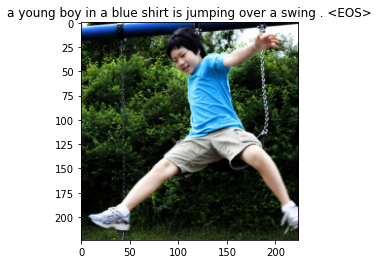

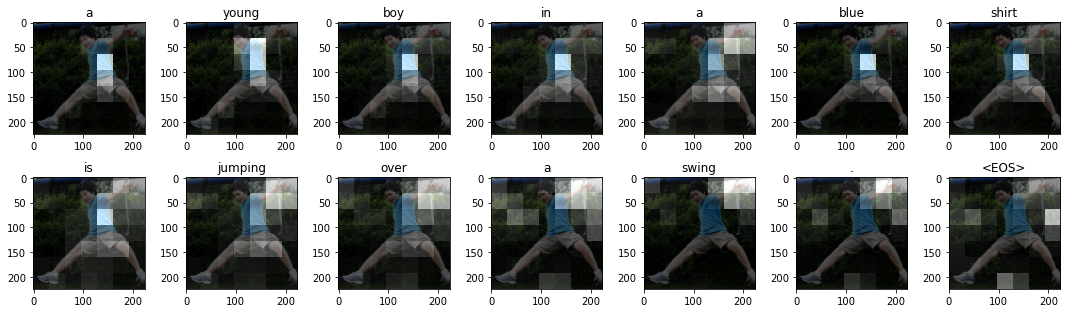

In [54]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

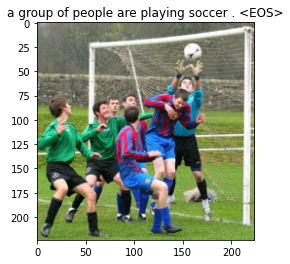

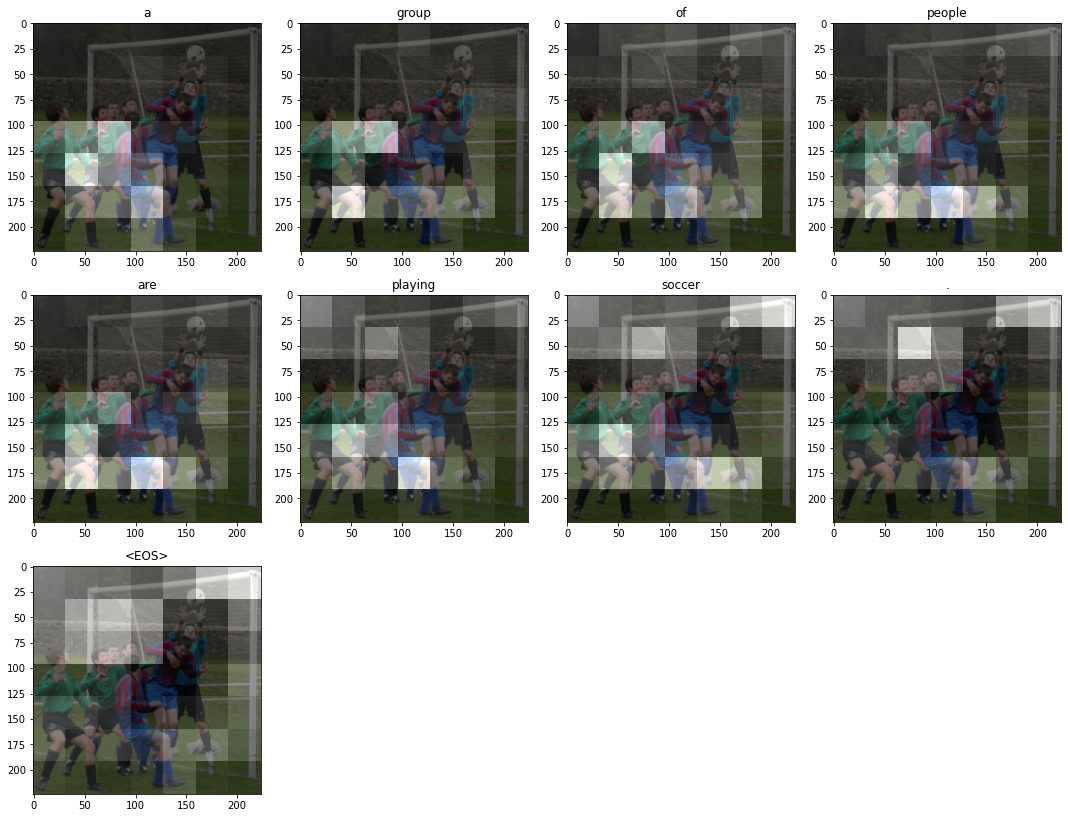

In [61]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

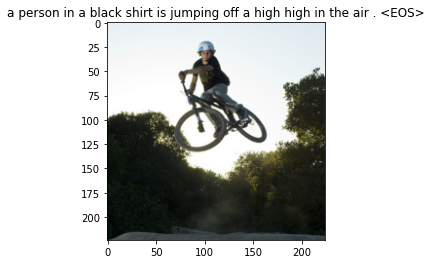

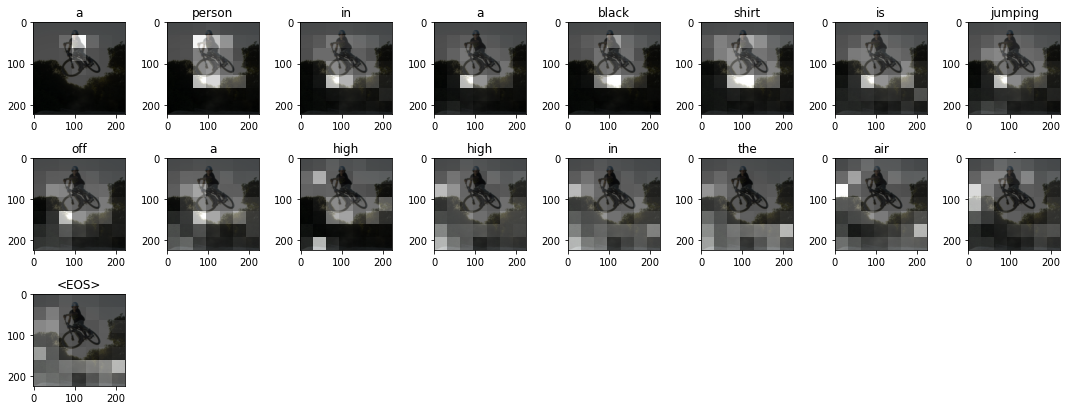

In [58]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

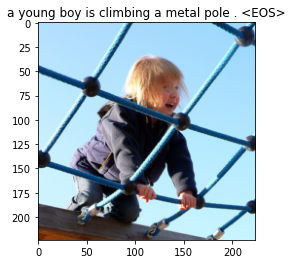

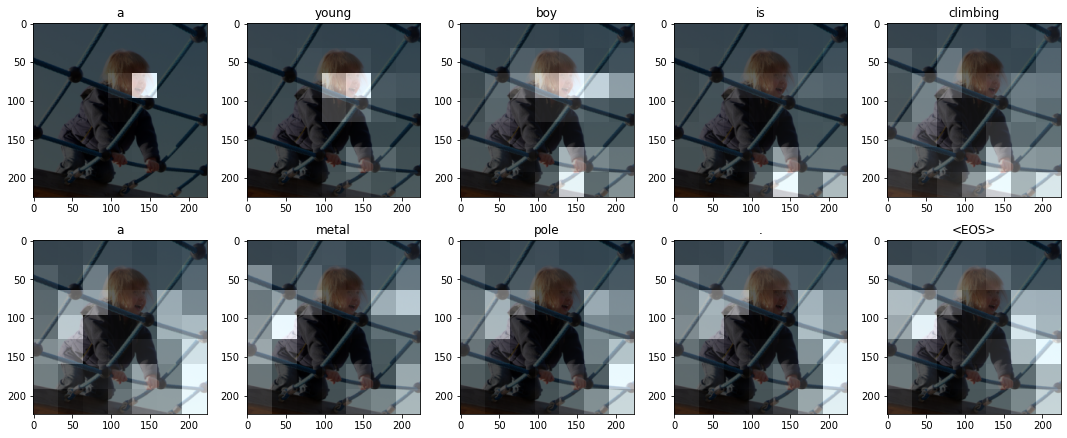

In [62]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

# 7 Test

In [47]:
params = torch.load('attention_model_state_proves.pth')

model = EncoderDecoder(
    embed_size = params['embed_size'],
    vocab_size = params['vocab_size'],
    attention_dim = params['attention_dim'],
    encoder_dim = params['encoder_dim'],
    decoder_dim = params['decoder_dim']
)

model.load_state_dict(params['state_dict'])

/home/alumne/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alumne/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [48]:
model.to(device)

EncoderDecoder(
  (encoder): EncoderCNN(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
 

In [18]:
def test(model, dataset, data,v_c):
    realcaption_list = []
    caption_lists = []
    images_list = []

    model.eval()
    with torch.no_grad():
        for images, realcaptions in data:
            images = images.to(device)
            realcaptions = realcaptions.to(device)

            vocab = list(dataset.vocab.itos.values())
            realcaption_letter = [[vocab[int(idx)] for idx in array] for array in realcaptions.cpu().numpy()]
            realcaption_list.extend(realcaption_letter)

            features = model.encoder(images)



            for feature, img in zip(features, images):
                feature = feature.unsqueeze(0)
                caps, alphas = model.decoder.generate_caption(feature, vocab=v_c)
                # caption = ' '.join(caps)
                caption_lists.append(caps)
                images_list.append(img.detach().cpu())

    return realcaption_list, caption_lists, images_list


In [19]:
print(len(data_loader_test))
print(len(dataset_test))

32
8091


In [21]:
real,predicted,image = test(model,dataset_test,data_loader_test,dataset.vocab)



In [22]:
len(real)

8091

In [23]:
len(predicted)

8091

In [24]:
len(image)

8091

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


El caption real és:
['<SOS>', 'a', 'girl', 'with', 'long', 'hair', 'flying', 'in', 'the', '<UNK>', 'while', 'she', 'swings', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'],
el que hem predit és:


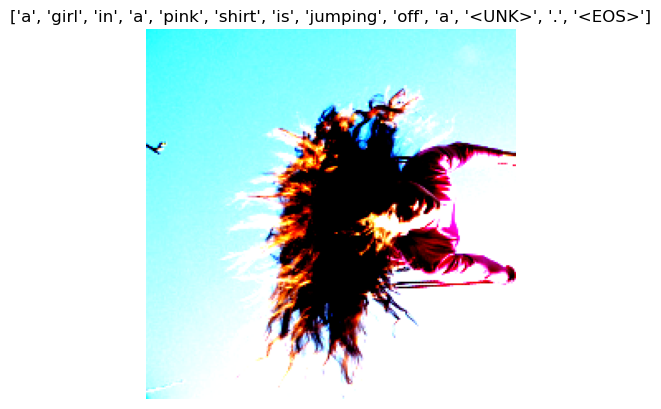

In [29]:
pos = 256
print(f'El caption real és:\n{real[pos]},\nel que hem predit és:')
imagen_individual = image[pos]
imagen_array = imagen_individual.numpy()
imagen_array = imagen_array.transpose((1, 2, 0))

plt.imshow(imagen_array)
plt.title(predicted[pos])
plt.axis('off')
plt.show()

In [30]:
def coeficiente_jaccard(captions_reales, captions_predichas):
    num_captions = min(len(captions_reales), len(captions_predichas))
    similitud = 0
    
    for i in range(num_captions):
        caption_real = [word if '<' not in word or word == '<UNK>' else '' for word in captions_reales[i]]
        caption_predicha = [word if '<' not in word or word == '<UNK>' else '' for word in captions_predichas[i]]

        caption_real = ' '.join(caption_real)
        caption_predicha = ' '.join(caption_predicha)


        # Convertir las captions en conjuntos de palabras únicas
        palabras_real = set(caption_real.split())
        palabras_predichas = set(caption_predicha.split())

        # Calcular el coeficiente de Jaccard
        intersection = palabras_real.intersection(palabras_predichas)
        union = palabras_real.union(palabras_predichas)
        similitud += len(intersection) / len(union)
        
    
    return similitud/num_captions



In [31]:
from nltk.translate.bleu_score import corpus_bleu

def bleu_score_funcition(captions_reales, captions_predichas):
    captions_reales = [' '.join([word if '<' not in word or word == '<UNK>' else '' for word in captions_reales[i]]) for i in range(len(captions_reales))]
    captions_predichas = [' '.join([word if '<' not in word or word == '<UNK>' else '' for word in captions_predichas[i]]) for i in range(len(captions_predichas))]
    references = [[caption_real.split()] for caption_real in captions_reales]
    hypotheses = [caption_predicha.split() for caption_predicha in captions_predichas]
    bleu = corpus_bleu(references, hypotheses)
    return bleu

#Com funciona:
# 1 es conta els n-grames de la real i la predita
# 2 es calcula la frequencia maxima de cada n-grama en les reals. Aixo es per evitar conta las misma ocurrencia de un n-grama més de una vegada
# 3 comparem els n-grama de la generada amb la real, i es calcula la seva precisio
# 4 obtenim el BLUE score, multiplicant la penalitzacio per brevetat per la precisio promitja.


In [32]:
jaccard = coeficiente_jaccard(real, predicted)

In [33]:
blue = bleu_score_funcition(real, predicted)

In [35]:
wandb.log({'Coefficient de Jaccard model': jaccard})
wandb.log({'Blue Score model': blue})

In [34]:
jaccard

0.24278631781812127

In [35]:
blue

0.0695933497126086

## TEST


In [58]:
#Initiate the Dataset and Dataloader

#setting the constants
data_location_proves =  "data/proves" # --> data

#defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
    T.Pad(10, fill=0, padding_mode='constant')
])

#testing the dataset class
dataset_proves =  FlickrDataset(
    root_dir = data_location_proves+"/Images",
    caption_file = data_location_proves+"/captions.txt",
    transform=transforms
)

#writing the dataloader
data_loader_proves = get_data_loader(
    dataset=dataset_proves,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    # batch_first=False
)

In [59]:
real_t,predicted_t,image_t = test(model,dataset_proves,data_loader_proves,dataset.vocab)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


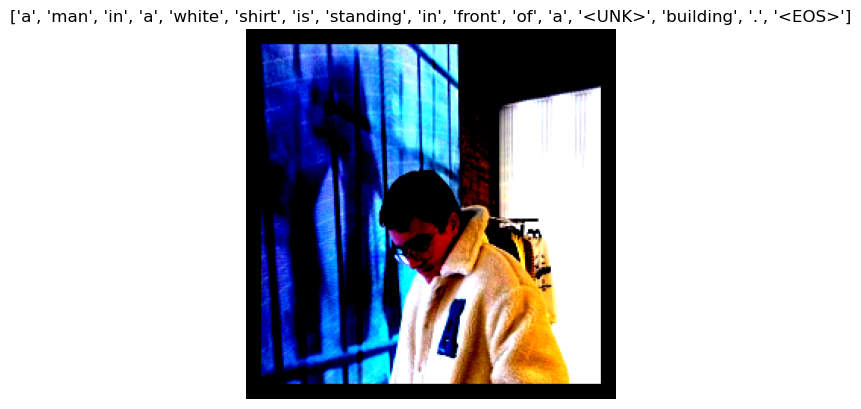

In [68]:
pos = 8
imagen_individual = image_t[pos]
imagen_array = imagen_individual.numpy()
imagen_array = imagen_array.transpose((1, 2, 0))

plt.imshow(imagen_array)
plt.title(predicted_t[pos])
plt.axis('off')
plt.show()